#[SpeedDating](https://www.openml.org/d/40536)

[Download dataset](https://www.openml.org/data/get_csv/13153954/speeddating.arff)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from pandas import read_csv
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import warnings
warnings.filterwarnings('ignore')
import time

#Basic Inspection

Substitució del caràcter '?' per *NaNs* i assignació de tipus.

In [ ]:
sd = read_csv("speeddating.csv", header=0, delimiter=',')
sd = sd.replace('?', np.nan)
sd = sd.drop(['has_null','wave'], axis= 1)
types = np.empty(len(sd.columns), dtype=object) 
types[0:1] = 'category'
types[1:4] = 'float'
types[4:8] = 'category'
types[8:10] = 'float'
types[10:13] = 'category'
types[13:19] = 'float'
types[19:25] = 'category'
types[25:31] = 'float'
types[31:37] = 'category'
types[37:43] = 'float'
types[43:49] = 'category'
types[49:54] = 'float'
types[54:59] = 'category'
types[59:65] = 'float'
types[65:71] = 'category'
types[71:88] = 'float'
types[88:105] = 'category'
types[105:106] = 'float'
types[106:107] = 'category'
types[107:110] = 'float'
types[110:113] = 'category'
types[113:115] = 'float'
types[115:117] = 'category'
types[117:118] = 'float'
types[118:121] = 'category'
index = 0
sdTypes = sd
for n in sd:
    sdTypes = sdTypes.astype({n:types[index]})
    index += 1
sd = sdTypes

#Data Cleaning

Eliminem les columnes amb menys relevancia i les que ja tenim la info per la diferencia

In [ ]:
l = [n[2:] for n in [x for x in sd.columns if x[0] == 'd' and x[1] == '_' and 'age' not in x] if n[2:] in sd.columns][:-5]
l.append('field')
l

['importance_same_race',
 'importance_same_religion',
 'pref_o_attractive',
 'pref_o_sincere',
 'pref_o_intelligence',
 'pref_o_funny',
 'pref_o_ambitious',
 'pref_o_shared_interests',
 'attractive_o',
 'sinsere_o',
 'intelligence_o',
 'funny_o',
 'ambitous_o',
 'shared_interests_o',
 'attractive_important',
 'sincere_important',
 'intellicence_important',
 'funny_important',
 'ambtition_important',
 'shared_interests_important',
 'attractive',
 'sincere',
 'intelligence',
 'funny',
 'ambition',
 'attractive_partner',
 'sincere_partner',
 'intelligence_partner',
 'funny_partner',
 'ambition_partner',
 'shared_interests_partner',
 'sports',
 'tvsports',
 'exercise',
 'dining',
 'museums',
 'art',
 'hiking',
 'gaming',
 'clubbing',
 'reading',
 'tv',
 'theater',
 'movies',
 'concerts',
 'music',
 'shopping',
 'yoga',
 'interests_correlate',
 'field']

In [ ]:
sd = sd.drop(columns=l)

Mirem quines tenen mes NaNs ara

In [ ]:
per = sd.isna().sum()*100/len(sd)
per.sort_values(ascending=False)

expected_num_interested_in_me    78.515159
expected_num_matches             14.000955
met                               4.476009
guess_prob_liked                  3.688231
like                              2.864646
                                   ...    
d_ambition_partner                0.000000
d_funny_partner                   0.000000
decision_o                        0.000000
d_sincere_partner                 0.000000
gender                            0.000000
Length: 71, dtype: float64

In [ ]:
sd = sd.drop(columns=['d_d_age', 'expected_num_interested_in_me', 'expected_num_matches'])

In [ ]:
sd = sd.assign(Count_NA = lambda x: x.isnull().sum(axis=1)*100/len(sd.columns)).sort_values('Count_NA', ascending=False)

In [ ]:
sd

,gender,age,age_o,d_age,race,race_o,samerace,d_importance_same_race,d_importance_same_religion,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,d_attractive_o,d_sinsere_o,d_intelligence_o,d_funny_o,d_ambitous_o,d_shared_interests_o,d_attractive_important,d_sincere_important,d_intellicence_important,d_funny_important,d_ambtition_important,d_shared_interests_important,d_attractive,d_sincere,d_intelligence,d_funny,d_ambition,d_attractive_partner,d_sincere_partner,d_intelligence_partner,d_funny_partner,d_ambition_partner,d_shared_interests_partner,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,d_interests_correlate,expected_happy_with_sd_people,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match,Count_NA
845,female,NaN,22.0,22.0,NaN,European/Caucasian-American,0,[0-1],[0-1],[21-100],[0-15],[16-20],[21-100],[0-15],[0-15],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-15],[0-15],[0-15],[0-15],[0-15],[0-15],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[-1-0],NaN,[0-4],[0-3],[0-2],NaN,NaN,[0-5],[0-4],NaN,0,0,0,8.823529
847,female,NaN,24.0,24.0,NaN,Other,0,[0-1],[0-1],[16-20],[16-20],[16-20],[16-20],[0-15],[0-15],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-15],[0-15],[0-15],[0-15],[0-15],[0-15],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[-1-0],NaN,[0-4],[0-3],[0-2],NaN,NaN,[0-5],[0-4],NaN,0,0,0,8.823529
843,female,NaN,21.0,21.0,NaN,European/Caucasian-American,0,[0-1],[0-1],[21-100],[0-15],[0-15],[0-15],[0-15],[0-15],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-15],[0-15],[0-15],[0-15],[0-15],[0-15],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[-1-0],NaN,[0-4],[0-3],[0-2],NaN,NaN,[0-5],[0-4],NaN,0,0,0,8.823529
842,female,NaN,26.0,26.0,NaN,European/Caucasian-American,0,[0-1],[0-1],[21-100],[0-15],[16-20],[16-20],[0-15],[0-15],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-15],[0-15],[0-15],[0-15],[0-15],[0-15],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[-1-0],NaN,[0-4],[0-3],[0-2],NaN,NaN,[0-5],[0-4],NaN,0,0,0,8.823529
839,female,NaN,22.0,22.0,NaN,Other,0,[0-1],[0-1],[16-20],[0-15],[16-20],[16-20],[0-15],[0-15],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-15],[0-15],[0-15],[0-15],[0-15],[0-15],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[-1-0],NaN,[0-4],[0-3],[0-2],NaN,NaN,[0-5],[0-4],NaN,0,0,0,8.823529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2888,female,25.0,23.0,2.0,'Black/African American',European/Caucasian-American,0,[2-5],[0-1],[16-20],[21-100],[16-20],[21-100],[0-15],[0-15],[6-8],[9-10],[6-8],[6-8],[6-8],[6-8],[0-15],[0-15],[16-20],[16-20],[16-20],[16-20],[9-10],[9-10],[9-10],[9-10],[9-10],[0-5],[6-8],[6-8],[6-8],[6-8],[6-8],[9-10],[6-8],[6-8],[9-10],[9-10],[9-10],[9-10],[0-5],[6-8],[6-8],[0-5],[6-8],[9-10],[9-10],[9-10],[9-10],[6-8],[0.33-1],5.0,[5-6],[0-3],[0-2],6.0,5.0,[6-8],[5-6],0.0,0,1,0,0.000000
2887,female,23.0,29.0,6.0,European/Caucasian-American,'Asian/Pacific Islander/Asian-American',0,[6-10],[2-5],[0-15],[16-20],[16-20],[

In [ ]:
sd = sd[sd.isnull().sum(axis=1) < 15]
sd = sd.drop(columns=['Count_NA'])

In [ ]:
per = sd.isna().sum()*100/len(sd)
per.sort_values(ascending=False)

met                              4.476009
guess_prob_liked                 3.688231
like                             2.864646
age_o                            1.241346
expected_happy_with_sd_people    1.205538
                                   ...   
d_shared_interests_partner       0.000000
d_ambition_partner               0.000000
d_funny_partner                  0.000000
d_intelligence_partner           0.000000
gender                           0.000000
Length: 68, dtype: float64

#Data Imputation

In [ ]:
sd = sd.sort_index()

In [ ]:
for col in sd.columns:
  sd[col].fillna(sd[col].mode()[0], inplace=True)
sd = sd.fillna(sd.median())

In [ ]:
sd.isna().sum().sort_values(ascending=False)

match                         0
d_funny_important             0
d_funny_o                     0
d_ambitous_o                  0
d_shared_interests_o          0
                             ..
d_tvsports                    0
d_sports                      0
d_shared_interests_partner    0
d_ambition_partner            0
gender                        0
Length: 68, dtype: int64

In [ ]:
sd

,gender,age,age_o,d_age,race,race_o,samerace,d_importance_same_race,d_importance_same_religion,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,d_attractive_o,d_sinsere_o,d_intelligence_o,d_funny_o,d_ambitous_o,d_shared_interests_o,d_attractive_important,d_sincere_important,d_intellicence_important,d_funny_important,d_ambtition_important,d_shared_interests_important,d_attractive,d_sincere,d_intelligence,d_funny,d_ambition,d_attractive_partner,d_sincere_partner,d_intelligence_partner,d_funny_partner,d_ambition_partner,d_shared_interests_partner,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,d_interests_correlate,expected_happy_with_sd_people,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,female,21.0,27.0,6.0,'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,[2-5],[2-5],[21-100],[16-20],[16-20],[16-20],[0-15],[0-15],[6-8],[6-8],[6-8],[6-8],[6-8],[6-8],[0-15],[16-20],[16-20],[0-15],[0-15],[0-15],[6-8],[6-8],[6-8],[6-8],[6-8],[6-8],[9-10],[6-8],[6-8],[6-8],[0-5],[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],[0-0.33],3.0,[0-4],[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0,1,0,0
1,female,21.0,22.0,1.0,'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,[2-5],[2-5],[21-100],[0-15],[0-15],[21-100],[0-15],[0-15],[6-8],[6-8],[9-10],[6-8],[6-8],[0-5],[0-15],[16-20],[16-20],[0-15],[0-15],[0-15],[6-8],[6-8],[6-8],[6-8],[6-8],[6-8],[6-8],[6-8],[6-8],[0-5],[6-8],[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],[0.33-1],3.0,[0-4],[0-3],[3-5],7.0,5.0,[6-8],[5-6],1.0,1,0,0
2,female,21.0,22.0,1.0,'Asian/Pacific Islander/Asian-American','Asian/Pacific Islander/Asian-American',1,[2-5],[2-5],[16-20],[16-20],[16-20],[16-20],[0-15],[0-15],[9-10],[9-10],[9-10],[9-10],[9-10],[9-10],[0-15],[16-20],[16-20],[0-15],[0-15],[0-15],[6-8],[6-8],[6-8],[6-8],[6-8],[0-5],[6-8],[9-10],[6-8],[0-5],[6-8],[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],[0-0.33],3.0,[0-4],[0-3],[3-5],7.0,5.0,[6-8],[0-4],1.0,1,1,1
3,female,21.0,23.0,2.0,'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,[2-5],[2-5],[21-100],[0-15],[0-15],[21-100],[0-15],[0-15],[6-8],[6-8],[9-10],[6-8],[9-10],[6-8],[0-15],[16-20],[16-20],[0-15],[0-15],[0-15],[6-8],[6-8],[6-8],[6-8],[6-8],[6-8],[6-8],[6-8],[6-8],[6-8],[6-8],[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],[0.33-1],3.0,[0-4],[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0,1,1,1
4,female,21.0,24.0,3.0,'Asian/Pacific Islander/Asian-American','Latino/Hispanic American',0,[2-5],[2-5],[21-100],[0-15],[16-20],[0-15],[0-15],[16-20],[6-8],[6-8],[9-10],[6-8],[9-10],[6-8],[0-15],[16-20],[16-20],[0-15],[0-15],[0-15],[6-8],[6-8],[6-8],[6-8],[6-8],[0-5],[6-8],[6-8],[6-8],[6-8],[6-8],[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],[0-0.33],3.0,[0-4],[0-3],[3-5],6.0,6.0,[6-8],[5-6],0.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,male,25.0,26.0,1.0,European/Caucasian-American,'Latino/Hispanic American',0,[0-1],[0-1],[0-15],[0-15],[21-100],[16-20],[0-15],[0-15],[9-10],[0-5],[0-5],[0-5],[6-8],[0-5],[21-100],[0-15],[0-15],[0-15],[0-15],[0-15],[6-8],[6-8],[6-8],[6-8],[6-8],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[0-5],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],[9-10],[6-8],[0-5],[6-8],[9-10],[9-10],[

#Outliers



##Age

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f01d7834160>],
      dtype=object)

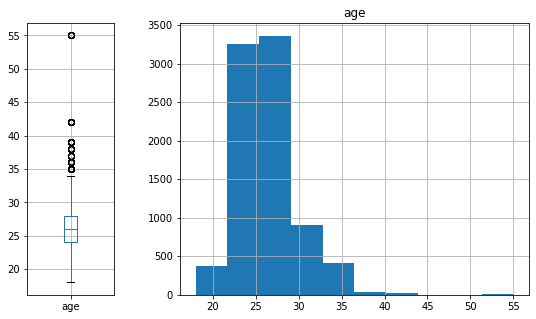

In [ ]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
sd.boxplot(column='age',ax=axes[0])
sd.hist(column='age',ax=axes[1])

In [ ]:
local_outlier_factor = LocalOutlierFactor(n_neighbors=20)
result = local_outlier_factor.fit_predict(sd['age'].values.reshape(-1, 1))

outliers = result == -1 
no_outliers = result == 1
Counter(result)

Counter({-1: 11, 1: 8367})

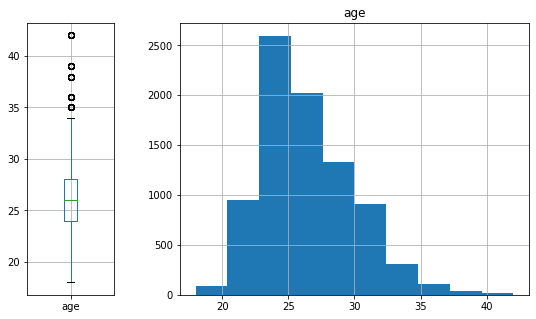

In [ ]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
sd[no_outliers].boxplot(column='age',ax=axes[0])
sd[no_outliers].hist(column='age',ax=axes[1])
sd = sd[sd.age != 55]

##Age_o

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f01d66a2470>],
      dtype=object)

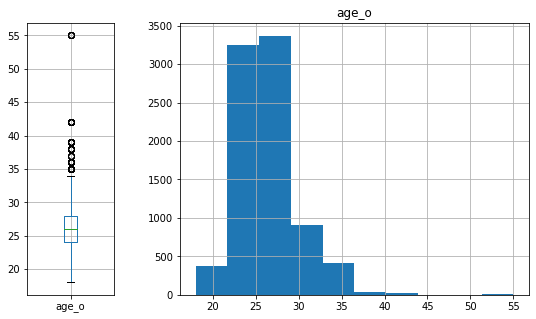

In [ ]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
sd.boxplot(column='age_o',ax=axes[0])
sd.hist(column='age_o',ax=axes[1])

In [ ]:
local_outlier_factor = LocalOutlierFactor(n_neighbors=20)
result = local_outlier_factor.fit_predict(sd['age_o'].values.reshape(-1, 1))

outliers = result == -1 
no_outliers = result == 1
Counter(result)

Counter({-1: 11, 1: 8361})

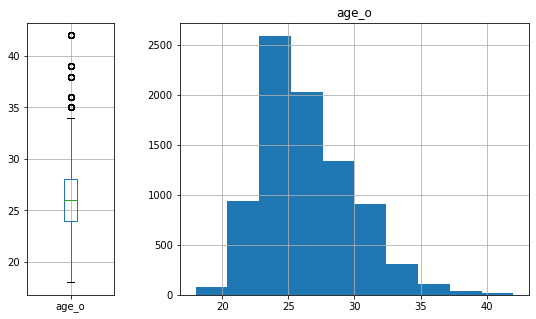

In [ ]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
sd[no_outliers].boxplot(column='age_o',ax=axes[0])
sd[no_outliers].hist(column='age_o',ax=axes[1])
sd = sd[sd.age_o != 55]

In [ ]:
sd.shape

(8366, 68)

#Visualization (pre-normalization)

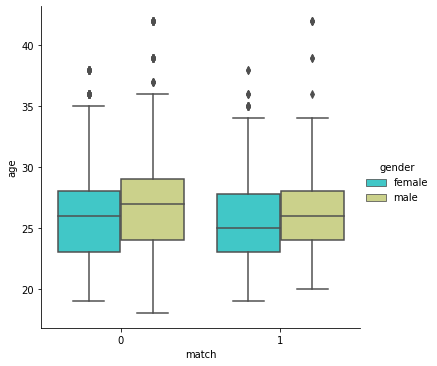

In [ ]:
sns.catplot(x='match',y='age',data=sd,palette='rainbow', hue='gender', kind="box")

#Normalization, standarization and encoding

In [ ]:
sd['d_pref_o_sincere'][0][0] == '['

True

In [ ]:
interval_categories = []
other_categories = []
for col in sd.columns:
  if sd[col].dtype != 'float':
    if str(sd[col][0])[0] == '[':
      interval_categories.append(col)
    else:
      other_categories.append(col)

In [ ]:
enc = OrdinalEncoder()
enc.fit(sd[interval_categories])
sd[interval_categories] = enc.transform(sd[interval_categories])


In [ ]:
sd[interval_categories].describe()

,d_importance_same_race,d_importance_same_religion,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,d_attractive_o,d_sinsere_o,d_intelligence_o,d_funny_o,d_ambitous_o,d_shared_interests_o,d_attractive_important,d_sincere_important,d_intellicence_important,d_funny_important,d_ambtition_important,d_shared_interests_important,d_attractive,d_sincere,d_intelligence,d_funny,d_ambition,d_attractive_partner,d_sincere_partner,d_intelligence_partner,d_funny_partner,d_ambition_partner,d_shared_interests_partner,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,d_interests_correlate,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,d_like,d_guess_prob_liked
count,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000
mean,0.941788,0.898518,1.060961,0.813053,1.110567,0.776476,0.214200,0.311618,0.749462,1.016973,1.067655,0.790103,0.851781,0.501673,1.063232,0.813650,1.111284,0.776954,0.214200,0.311858,0.981951,1.438561,1.233325,1.446091,1.179536,0.750418,1.018169,1.068850,0.791059,0.852379,0.502152,0.893378,0.477289,0.822615,1.251494,1.008845,0.913101,0.701171,0.312336,0.718384,1.255200,0.602438,0.964021,1.314248,0.979441,1.287354,0.690055,0.438800,1.065862,1.036816,0.201530,0.576859,0.721133,0.913818
std,0.791214,0.793793,0.808126,0.713261,0.691052,0.698389,0.437095,0.540374,0.629127,0.616528,0.594426,0.633723,0.653850,0.611063,0.807877,0.713333,0.690590,0.698200,0.437095,0.540457,0.506063,0.587367,0.598119,0.543085,0.664382,0.628747,0.615912,0.593685,0.633473,0.653529,0.611062,0.775668,0.670904,0.724167,0.664788,0.697476,0.717956,0.712532,0.545247,0.680574,0.705384,0.660355,0.730038,0.636679,0.707442,0.668942,0.735840,0.649996,0.793481,0.718691,0.563295,0.688917,0.588229,0.781500
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,2.000000,2.000000,2.0000

In [ ]:
dummies = pd.get_dummies(sd[other_categories])
dummies

,gender_female,gender_male,race_'Asian/Pacific Islander/Asian-American',race_'Black/African American',race_'Latino/Hispanic American',race_European/Caucasian-American,race_Other,race_o_'Asian/Pacific Islander/Asian-American',race_o_'Black/African American',race_o_'Latino/Hispanic American',race_o_European/Caucasian-American,race_o_Other,samerace_0,samerace_1,decision_0,decision_1,decision_o_0,decision_o_1,match_0,match_1
0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0
1,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0
2,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1
3,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1
4,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0
8374,0,1,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0
8375,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0
8376,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,1,0


In [ ]:
dummies = dummies.drop(['gender_male','samerace_0', 'decision_0', 'decision_1', 'decision_o_0', 'decision_o_1', 'match_0'], axis= 1)
dummies.rename(columns = {'samerace_1':'samerace', 'match_1': 'match'}, inplace = True) 
dummies

,gender_female,race_'Asian/Pacific Islander/Asian-American',race_'Black/African American',race_'Latino/Hispanic American',race_European/Caucasian-American,race_Other,race_o_'Asian/Pacific Islander/Asian-American',race_o_'Black/African American',race_o_'Latino/Hispanic American',race_o_European/Caucasian-American,race_o_Other,samerace,match
0,1,1,0,0,0,0,0,0,0,1,0,0,0
1,1,1,0,0,0,0,0,0,0,1,0,0,0
2,1,1,0,0,0,0,1,0,0,0,0,1,1
3,1,1,0,0,0,0,0,0,0,1,0,0,1
4,1,1,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,0,0,0,0,1,0,0,0,1,0,0,0,0
8374,0,0,0,0,1,0,0,0,0,0,1,0,0
8375,0,0,0,0,1,0,0,0,1,0,0,0,0
8376,0,0,0,0,1,0,1,0,0,0,0,0,0


In [ ]:
sd = sd.drop(columns=other_categories)
sd = pd.concat([sd, dummies], axis=1)
sd

,age,age_o,d_age,d_importance_same_race,d_importance_same_religion,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,d_attractive_o,d_sinsere_o,d_intelligence_o,d_funny_o,d_ambitous_o,d_shared_interests_o,d_attractive_important,d_sincere_important,d_intellicence_important,d_funny_important,d_ambtition_important,d_shared_interests_important,d_attractive,d_sincere,d_intelligence,d_funny,d_ambition,d_attractive_partner,d_sincere_partner,d_intelligence_partner,d_funny_partner,d_ambition_partner,d_shared_interests_partner,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,d_interests_correlate,expected_happy_with_sd_people,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,gender_female,race_'Asian/Pacific Islander/Asian-American',race_'Black/African American',race_'Latino/Hispanic American',race_European/Caucasian-American,race_Other,race_o_'Asian/Pacific Islander/Asian-American',race_o_'Black/African American',race_o_'Latino/Hispanic American',race_o_European/Caucasian-American,race_o_Other,samerace,match
0,21.0,27.0,6.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,2.0,2.0,1.0,0.0,1.0,3.0,0.0,0.0,1.0,7.0,6.0,1.0,1.0,0.0,1,1,0,0,0,0,0,0,0,1,0,0,0
1,21.0,22.0,1.0,1.0,1.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,2.0,2.0,1.0,0.0,2.0,3.0,0.0,0.0,1.0,7.0,5.0,1.0,1.0,1.0,1,1,0,0,0,0,0,0,0,1,0,0,0
2,21.0,22.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,2.0,2.0,1.0,0.0,1.0,3.0,0.0,0.0,1.0,7.0,5.0,1.0,0.0,1.0,1,1,0,0,0,0,1,0,0,0,0,1,1
3,21.0,23.0,2.0,1.0,1.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,2.0,2.0,1.0,0.0,2.0,3.0,0.0,0.0,1.0,7.0,6.0,1.0,1.0,0.0,1,1,0,0,0,0,0,0,0,1,0,0,1
4,21.0,24.0,3.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,2.0,2.0,1.0,0.0,1.0,3.0,0.0,0.0,1.0,6.0,6.0,1.0,1.0,0.0,1,1,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,25.0,26.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,1.0,0.0,2.0,1.0,0.0,1.0,2.0,2.0,2.0,1.0,0.0,2.0,10.0,2.0,0.0,1.0,2.0,5.0,0.0,1.0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,0
8374,25.0,24.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,1.0,0.0,2.0,1.0,0.0,1.0,2.0,2.0,2.0,1.0,0.0,2.0,10.0,2.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,1,0,0
8375,25.0,29.0,4.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,1.0,0.0,2.0,1.0,0.0,1.0,2.0,2.0,2.0,1.0,0.0,0.0,10.0,2.0,0.0,1.0,6.0,5.0,1.0,1.0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,0
8376,25.0,22.0,3.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,1.0,0.0,2.0,1.0,0.0,1.0,2.0,2.0,2.0,1.0,0.0,2.0,1

In [ ]:
min_max_scaler =  preprocessing.MinMaxScaler()
for col in sd:
  sd[[col]] = min_max_scaler.fit_transform(sd[[col]])

In [ ]:
#sd.to_csv('speeddating_preproc', index=False)
#sd.describe()

#CV

In [ ]:
#sd = read_csv("speeddating_preprocessed.csv", header=0, delimiter=',')
X = sd.loc[:,sd.columns != 'match']
y = sd['match']

In [ ]:
models = [LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(), LogisticRegression(max_iter=400), LinearSVC()]
models_strings = ['LinearDiscriminantAnalysis' , 'QuadraticDiscriminantAnalysis' , 'LogisticRegression', 'LinearSVC']
LDAparams = {
    'solver' : ['svd', 'lsqr'],
    'shrinkage' : [None, 'auto'],
}
QDAparams = {
    'reg_param': [0.1, 0.2, 0.3, 0.4, 0.5, 1],
}

LogRegparams = {
    'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.1, 0.25, 0.5, 0.75, 1, 1.5, 1.25, 2, 2.5],
    'solver' : ['liblinear', 'sag', 'saga'] 
}

LinearSVCparams = {
    'penalty': ['l1', 'l2'], #nomes hi ha aquestes dos opcions
    'loss': ['hinge', 'squared_hinge'], #nomes hi ha aquestes dos opcions
    'C': [0.1, 0.25, 0.5, 0.75, 1, 1.5, 1.25, 2, 2.5],
}

params = [LDAparams, QDAparams, LogRegparams, LinearSVCparams]

In [ ]:
for i, model in enumerate(models):
  print(models_strings[i])
  start = time.time()
  for k in range(2,15):
    start_k = time.time()
    cv = KFold(n_splits=k, shuffle=True, random_state=420)
    gs = GridSearchCV(model,params[i], scoring='accuracy', n_jobs= -1, cv=cv)
    gs.fit(X, y)
    print("\t params: {} || score: {} || k: {} || time: {}".format(gs.best_params_, gs.best_score_, k, time.time()-start_k))
  print("{} took {} seconds".format(models_strings[i], time.time()-start))

LinearDiscriminantAnalysis
	 params: {'shrinkage': None, 'solver': 'svd'} || score: 0.8474778866841979 || k: 2 || time: 1.8210828304290771
	 params: {'shrinkage': None, 'solver': 'svd'} || score: 0.847357350621995 || k: 3 || time: 0.8413295745849609
	 params: {'shrinkage': None, 'solver': 'svd'} || score: 0.8477163121929273 || k: 4 || time: 1.0992214679718018
	 params: {'shrinkage': None, 'solver': 'svd'} || score: 0.8480738784018579 || k: 5 || time: 1.3119704723358154
	 params: {'shrinkage': None, 'solver': 'lsqr'} || score: 0.8499861156106817 || k: 6 || time: 1.5717785358428955
	 params: {'shrinkage': None, 'solver': 'lsqr'} || score: 0.8499860063531156 || k: 7 || time: 1.8443775177001953
	 params: {'shrinkage': None, 'solver': 'svd'} || score: 0.8491483848243937 || k: 8 || time: 2.143033742904663
	 params: {'shrinkage': None, 'solver': 'svd'} || score: 0.848432880256902 || k: 9 || time: 2.2029950618743896
	 params: {'shrinkage': None, 'solver': 'svd'} || score: 0.8491491027993574 ||

KeyboardInterrupt: ignored

#Model Evaluation

In [ ]:
#sd = read_csv("speeddating_preprocessed.csv", header=0, delimiter=',')
X = sd.loc[:,sd.columns != 'match']
y = sd['match']

##Linear/Quadratic

###LDA

In [ ]:
lda = LinearDiscriminantAnalysis(shrinkage = None, solver = 'lsqr')
kf = KFold(n_splits=6, shuffle=True, random_state=420)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
lda.fit(X_train,y_train)
lda_pred = lda.predict(X_test)
r2_lda = lda.score(X_test,y_test)

print('Mean sqared error with validation data: {}'.format(mean_squared_error(y_test,lda_pred)))
print('R2 score with validation data: {}'.format(r2_lda))
print('Coefficients: \n', lda.coef_)

In [ ]:
lda_coef_table = pd.DataFrame(list(X_train.columns)).copy()
lda_coef_table.insert(len(lda_coef_table.columns),"Coefs",lda.coef_.transpose())

In [ ]:
lda_coef_table.sort_values(by = 'Coefs', ascending=False)

In [ ]:
labels = lda_coef_table.sort_values(by=['Coefs']).head(5)
labels = labels.append(lda_coef_table.sort_values(by=['Coefs']).tail(5))
labels = labels.loc[:,0]
labels

In [ ]:
mean_coef_table = lda_coef_table.drop(labels.index,axis= 0)
mean_coef_table.sort_values(by = 'Coefs', ascending=False)

In [ ]:
np.mean(mean_coef_table.Coefs)

####Visualization

In [ ]:
n = 5

In [ ]:
lda_coefs = lda_coef_table.sort_values(by = 'Coefs', ascending=False)
lda_coefs.columns = ['Feature','Coeficients']
plt.xticks(rotation=90)
sns.barplot(x="Feature", y="Coeficients", data=pd.concat([lda_coefs.head(n), lda_coefs.tail(n)])).set_title('Most important features')

###Logistic Regression

In [ ]:
lreg = LogisticRegression(max_iter=400, C = 1, penalty= 'l1', solver = 'liblinear')
kf = KFold(n_splits=13, shuffle=True, random_state=420)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [ ]:
lreg.fit(X_train,y_train)
lreg_pred = lreg.predict(X_test)
r2_lreg = lreg.score(X_test,y_test)

print('Mean sqared error with validation data: {}'.format(mean_squared_error(y_test,lreg_pred)))
print('R2 score with validation data: {}'.format(r2_lreg))
print('Coefficients: \n', lreg.coef_)

In [ ]:
lreg_coef_table = pd.DataFrame(list(X_train.columns)).copy()
lreg_coef_table.insert(len(lreg_coef_table.columns),"Coefs",lreg.coef_.transpose())
lreg_coef_table.sort_values(by = 'Coefs', ascending=False)

In [ ]:
labels = lreg_coef_table.sort_values(by=['Coefs']).head(5)
labels = labels.append(lreg_coef_table.sort_values(by=['Coefs']).tail(5))
labels = labels.loc[:,0]
labels

In [ ]:
mean_coef_table = lreg_coef_table.drop(labels.index,axis= 0)
mean_coef_table.sort_values(by = 'Coefs', ascending=False)
np.mean(mean_coef_table.Coefs)

####Visualization

In [ ]:
logreg_coefs = lreg_coef_table.sort_values(by = 'Coefs', ascending=False)
logreg_coefs.columns = ['Feature','Coeficients']
plt.xticks(rotation=90)
sns.barplot(x="Feature", y="Coeficients", data=pd.concat([logreg_coefs.head(n), logreg_coefs.tail(n)])).set_title('Most important features')

###Linear SVM

In [ ]:
svm = LinearSVC(C = 2, loss = 'squared_hinge', penalty = 'l2')
kf = KFold(n_splits=9, shuffle=True, random_state=420)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
svm.fit(X_train,y_train)
svm_pred = svm.predict(X_test)
r2_svm = svm.score(X_test,y_test)

print('Mean sqared error with validation data: {}'.format(mean_squared_error(y_test,svm_pred)))
print('R2 score with validation data: {}'.format(r2_svm))
print('Coefficients: \n', svm.coef_)

In [ ]:
svm_coef_table = pd.DataFrame(list(X_train.columns)).copy()
svm_coef_table.insert(len(svm_coef_table.columns),"Coefs",svm.coef_.transpose())
svm_coef_table.sort_values(by = 'Coefs', ascending=False)

In [ ]:
labels = svm_coef_table.sort_values(by=['Coefs']).head(5)
labels = labels.append(svm_coef_table.sort_values(by=['Coefs']).tail(5))
labels = labels.loc[:,0]
labels

In [ ]:
mean_coef_table = svm_coef_table.drop(labels.index,axis= 0)
mean_coef_table.sort_values(by = 'Coefs', ascending=False)
np.mean(mean_coef_table.Coefs)

####Visualization

In [ ]:
svm_coefs = svm_coef_table.sort_values(by = 'Coefs', ascending=False)
svm_coefs.columns = ['Feature','Coeficients']
plt.xticks(rotation=90)
sns.barplot(x="Feature", y="Coeficients", data=pd.concat([svm_coefs.head(n), svm_coefs.tail(n)])).set_title('Most important features')

##Non-Linear

In [ ]:
X = sd.loc[:,sd.columns != 'match']
y = sd['match']

###SVM RBF Kernel

In [ ]:
C_range = [0.01, 1, 10, 100, 200]
gamma_range = [0.01, 1, 10, 100]
param_grid = {
    "C" : C_range,
    "gamma" : gamma_range,
}

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=420)
gs = GridSearchCV(SVC(),param_grid, scoring='accuracy', n_jobs= -1, cv=cv)
gs.fit(X, y)
print("\t params: {} || score: {}".format(gs.best_params_, gs.best_score_))

####Evaluation

In [ ]:
svm_rbf =  SVC(kernel = 'rbf', C = 100,gamma = 0.01, random_state = 420)
kf = KFold(n_splits=5, shuffle=True, random_state=420)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [ ]:
svm_rbf.fit(X_train,y_train)
rbf_pred = svm_rbf.predict(X_test)
r2_rbf = svm_rbf.score(X_test,y_test)
print('Mean sqared error with validation data: {}'.format(mean_squared_error(y_test,rbf_pred)))
print('R2 score with validation data: {}'.format(r2_rbf))

###Random Forest

In [ ]:
params = {
    'n_estimators' : [10, 100, 200, 400, 600, 800, 1000, 1500, 2000],
    'max_depth': [10, 25, 50, 60, 75, 100, None],
    'max_features': ['auto', 'sqrt'],
}
gs = GridSearchCV(RandomForestClassifier(),params, scoring='accuracy', n_jobs= -1)
gs.fit(X, y)
print("\t params: {} || score: {}".format(gs.best_params_, gs.best_score_))

####Evaluation

In [ ]:
rfc = RandomForestClassifier()
kf = KFold(n_splits=5, shuffle=True, random_state=420)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)
r2_rfc = rfc.score(X_test,y_test)

print('Mean sqared error with validation data: {}'.format(mean_squared_error(y_test,rfc_pred)))
print('R2 score with validation data: {}'.format(r2_rfc))
print('Coefficients: \n', rfc.feature_importances_)

In [ ]:
rfc_coef_table = pd.DataFrame(list(X_train.columns)).copy()
rfc_coef_table.insert(len(rfc_coef_table.columns),"Coefs",rfc.feature_importances_.transpose())
rfc_coef_table.sort_values(by = 'Coefs', ascending=False)

In [ ]:
labels = rfc_coef_table.sort_values(by=['Coefs']).head(5)
labels = labels.append(rfc_coef_table.sort_values(by=['Coefs']).tail(5))
labels = labels.loc[:,0]
labels

In [ ]:
mean_coef_table = rfc_coef_table.drop(labels.index,axis= 0)
mean_coef_table.sort_values(by = 'Coefs', ascending=False)
np.mean(mean_coef_table.Coefs)

####Visualization

In [ ]:
rfc_coefs = rfc_coef_table.sort_values(by = 'Coefs', ascending=False)
rfc_coefs.columns = ['Feature','Coeficients']
plt.xticks(rotation=90)
sns.barplot(x="Feature", y="Coeficients", data=pd.concat([rfc_coefs.head(n), rfc_coefs.tail(n)])).set_title('Most important features')